In [1]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [4]:
# importing  custom particle_net keras model 
!wget https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py -O tf_keras_model.py

--2022-06-19 10:09:36--  https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6795 (6.6K) [text/plain]
Saving to: ‘tf_keras_model.py’

tf_keras_model.py   100%[===================>]   6.64K  --.-KB/s    in 0s      

2022-06-19 10:09:36 (64.8 MB/s) - ‘tf_keras_model.py’ saved [6795/6795]



In [7]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net_lite_custom

Data are imported in .npy format from Dropbox 

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

data_folder = "/content/drive/MyDrive/datiML"
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!wget https://www.dropbox.com/sh/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a?dl=1 -O keras_input.zip
!unzip keras_input.zip

data_folder = "."

--2022-06-19 10:32:21--  https://www.dropbox.com/sh/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a [following]
--2022-06-19 10:32:22--  https://www.dropbox.com/sh/dl/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb0f9650dcd34334644e4d1aac2.dl.dropboxusercontent.com/zip_download_get/BK7x6fMlPpq-LjqDVNBoeGDHsuJRVTPyRqHMv28TytfLzcE1-5GxSh8xzY5XwSIT0snFb3Zx7vHQgPUKy4JyIsinfcgt3oeOvOlG85BRP-zr3Q?dl=1# [following]
--2022-06-19 10:32:22--  https://ucb0f9650dcd34334644e4d1aac2.dl.dropboxusercontent.com/zip_download_get/BK7x6fMlPpq-LjqDVNBoeGDHsuJRVTPyRqHMv28TytfLzcE1-5GxSh8xzY5XwSIT0snFb3Zx7v

There are three type of samples:
- Photons from Radiative Muon Capture, as signal
- Min-bias events due to the beam, as background
- Cosmic rays, as background

All the samples represent clusters in the upstream calorimeter disk.

The datasets are saved as dictionaries with 4 components:
-  "points": Point Cloud (xy coordinates of each hit of a cluster) - padded to 50 maximum hits
-  "features": Energy and Time of each hit of a cluster - paddes to 50 maximum hits
-  "mask": Mask to distinguish real hits (the others are filled with 0) in a cluster
-  "summary": Energy, Time, Radius, and Number of active cells for a cluster

In [12]:
name_map = {"points": "xy", "features": "et", "mask": "mask", "summary": "etrn"}

signal  = {key: np.load(f"{data_folder}/signal_{ name_map[key]}.npy") for key in name_map}

mnbs    = {key: np.load(f"{data_folder}/mnbs_{   name_map[key]}.npy") for key in name_map}

cosmics = {key: np.load(f"{data_folder}/cosmics_{name_map[key]}.npy") for key in name_map}

The dataset (generated with Monte Carlo) is weighted to match the real statistics of the data in one Mu2e injection cycle (1.33 s).


In [13]:
'''
cluster su disco upstream in un injection cycle (1.33s):
RMC: 330
MNBS: 1.3M
cosmici: 4

cluster simulati su disco 0:
RMC: 150k
MNBS: 1.05M
cosmici: 53k

pesi:
RMC: 66/150k 
MNBS: 
Cosmici: 4/53k
'''

signal_weight = 330/150e3 * 100
mnbs_weight = 0.24 * 100
cosmics_weight = 4/53e3 * 100

'''
il campione MC è stato filtrato con ROOT
effettuando due tagli di preselezione:
E del cluster > 50 MeV  &&  R del centroide del cluster > 480 mm
'''

print(end="")

The samples are merged into a unique dataset, which is then shuffled, saving also labels and weights

In [14]:
S =  signal["mask"].shape[0] #entries segnale
F =    mnbs["mask"].shape[0] #entries mnbs (background flash da fascio)
C = cosmics["mask"].shape[0] #entries cosmici

N = S + F + C

p = np.random.permutation(N) #

In [15]:
data = {key: np.concatenate( (signal[key], mnbs[key], cosmics[key]) )[p] for key in name_map}

label_list = [1, 0, 0]
entries_list = [S, F, C]
weight_list = [signal_weight, mnbs_weight, cosmics_weight]

print(f"- Entries per signale, mnbs e cosmici:{entries_list}")
print(f"- Pesi per signale, mnbs e cosmici:{weight_list}")

label = np.concatenate( 
    [ np.ones((e))*l for e, l in zip(entries_list,  label_list) ]
)[p]

sample_weight = np.concatenate( 
    [ np.ones((e))*w for e, w in zip(entries_list, weight_list) ]
)[p]

- Entries per signale, mnbs e cosmici:[41372, 1132, 41598]
- Pesi per signale, mnbs e cosmici:[0.22, 24.0, 0.007547169811320755]


The data are normalized to help the training 

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for key in ["points", "features"]:
  data[key][data["mask"].reshape(N, 50)] = scaler.fit_transform(data[key][data["mask"].reshape(N, 50)])

data["summary"] = scaler.fit_transform(data["summary"])

The dataset is split in training, validation and test set

In [17]:
train_data  = {key: data[key][int(N*0.0) : int(N*0.7)] for key in name_map}
test_data   = {key: data[key][int(N*0.7) : int(N*0.9)] for key in name_map}
val_data    = {key: data[key][int(N*0.9) : int(N*1.0)] for key in name_map}

train_label = label[int(N*0.0) : int(N*0.7)]
test_label  = label[int(N*0.7) : int(N*0.9)]
val_label   = label[int(N*0.9) : int(N*1.0)]

train_weight = sample_weight[int(N*0.0) : int(N*0.7)]
test_weight  = sample_weight[int(N*0.7) : int(N*0.9)]
val_weight   = sample_weight[int(N*0.9) : int(N*1.0)]

The keras model is imported from the library 

In [33]:
input_shapes = {'points': (50, 2), 'features': (50, 2), 'mask':(50, 1)}

model = get_particle_net_lite_custom(input_shapes)

In [19]:
# Training parameters

batch_size = 1024
epochs = 30

The learning rate is exponentially decreased by a 0.1 factor every 10 epochs, starting from 0.01. The best initial learning rate was estimated using the learning rate finder technique (https://colab.research.google.com/github/sachinruk/blog/blob/master/_notebooks/2021-02-15-Tensorflow-Learning-Rate-Finder.ipynb)

In [20]:
def lr_schedule(epoch):
    lr = 1e-2
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

The model is compiled with:
- Loss: binary crossentropy
- Metrics (weighted to match the real statistics): accuracy, precision and recall
- Optimizer: Adam

In [34]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              weighted_metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

[2022-06-19 10:42:37,919] INFO: Learning rate: 0.010000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 50, 1)]      0           []                               
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, 50, 1)       0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_2 (TFOpLambda)         (None, 50, 1)        0           ['tf.math.not_equal_1[0][0]']    
                                                                                                  
 tf.math.equal_1 (TFOpLambda)   (None, 50, 1)        0           ['tf.cast_2[0][0]']    

Keras checkpoints are employed to save the model with the best validation accuracy

In [35]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % "lite"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, progress_bar, lr_scheduler]

In [ ]:
history = model.fit(
    [train_data["points"], train_data["features"], train_data["mask"], train_data["summary"]], 
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_data["points"], val_data["features"], val_data["mask"], val_data["summary"]], val_label, val_weight),
    shuffle=True,
    sample_weight=train_weight,
    callbacks=callbacks
)

Epoch 1/30


[2022-06-19 10:42:52,307] INFO: Learning rate: 0.010000


      0/Unknown - 10s 0s/sample - loss: 0.1242 - accuracy: 0.8817 - precision_1: 0.8182 - recall_1: 0.6678
Epoch 1: val_loss improved from inf to 0.12936, saving model to model_checkpoints/lite_model.001.h5
58/58 [==============================] - 14s 236ms/sample - loss: 0.1242 - accuracy: 0.8817 - precision_1: 0.8182 - recall_1: 0.6678 - val_loss: 0.1294 - val_accuracy: 0.8527 - val_precision_1: 0.7265 - val_recall_1: 0.6560
Epoch 2/30


[2022-06-19 10:43:06,005] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0870 - accuracy: 0.9141 - precision_1: 0.8306 - recall_1: 0.8180
Epoch 2: val_loss improved from 0.12936 to 0.09548, saving model to model_checkpoints/lite_model.002.h5
58/58 [==============================] - 9s 162ms/sample - loss: 0.0870 - accuracy: 0.9141 - precision_1: 0.8306 - recall_1: 0.8180 - val_loss: 0.0955 - val_accuracy: 0.8895 - val_precision_1: 0.7645 - val_recall_1: 0.8040
Epoch 3/30


[2022-06-19 10:43:15,412] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0787 - accuracy: 0.9312 - precision_1: 0.8756 - recall_1: 0.8399
Epoch 3: val_loss improved from 0.09548 to 0.07530, saving model to model_checkpoints/lite_model.003.h5
58/58 [==============================] - 9s 163ms/sample - loss: 0.0787 - accuracy: 0.9312 - precision_1: 0.8756 - recall_1: 0.8399 - val_loss: 0.0753 - val_accuracy: 0.9308 - val_precision_1: 0.9546 - val_recall_1: 0.7583
Epoch 4/30


[2022-06-19 10:43:24,872] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0800 - accuracy: 0.9241 - precision_1: 0.8589 - recall_1: 0.8276
Epoch 4: val_loss improved from 0.07530 to 0.07152, saving model to model_checkpoints/lite_model.004.h5
58/58 [==============================] - 9s 163ms/sample - loss: 0.0800 - accuracy: 0.9241 - precision_1: 0.8589 - recall_1: 0.8276 - val_loss: 0.0715 - val_accuracy: 0.9394 - val_precision_1: 0.8456 - val_recall_1: 0.9260
Epoch 5/30


[2022-06-19 10:43:34,323] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0719 - accuracy: 0.9375 - precision_1: 0.8848 - recall_1: 0.8576
Epoch 5: val_loss did not improve from 0.07152
58/58 [==============================] - 9s 160ms/sample - loss: 0.0719 - accuracy: 0.9375 - precision_1: 0.8848 - recall_1: 0.8576 - val_loss: 0.0920 - val_accuracy: 0.9173 - val_precision_1: 0.8345 - val_recall_1: 0.8335
Epoch 6/30


[2022-06-19 10:43:43,634] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0618 - accuracy: 0.9496 - precision_1: 0.8999 - recall_1: 0.8947
Epoch 6: val_loss did not improve from 0.07152
58/58 [==============================] - 9s 159ms/sample - loss: 0.0618 - accuracy: 0.9496 - precision_1: 0.8999 - recall_1: 0.8947 - val_loss: 0.0734 - val_accuracy: 0.9538 - val_precision_1: 0.8731 - val_recall_1: 0.9533
Epoch 7/30


[2022-06-19 10:43:52,863] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0599 - accuracy: 0.9513 - precision_1: 0.9108 - recall_1: 0.8893
Epoch 7: val_loss did not improve from 0.07152
58/58 [==============================] - 9s 159ms/sample - loss: 0.0599 - accuracy: 0.9513 - precision_1: 0.9108 - recall_1: 0.8893 - val_loss: 0.1304 - val_accuracy: 0.8912 - val_precision_1: 0.7148 - val_recall_1: 0.9372
Epoch 8/30


[2022-06-19 10:44:02,078] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0653 - accuracy: 0.9457 - precision_1: 0.8999 - recall_1: 0.8771
Epoch 8: val_loss did not improve from 0.07152
58/58 [==============================] - 9s 158ms/sample - loss: 0.0653 - accuracy: 0.9457 - precision_1: 0.8999 - recall_1: 0.8771 - val_loss: 0.0751 - val_accuracy: 0.9393 - val_precision_1: 0.8333 - val_recall_1: 0.9456
Epoch 9/30


[2022-06-19 10:44:11,281] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0622 - accuracy: 0.9483 - precision_1: 0.8971 - recall_1: 0.8923
Epoch 9: val_loss did not improve from 0.07152
58/58 [==============================] - 9s 159ms/sample - loss: 0.0622 - accuracy: 0.9483 - precision_1: 0.8971 - recall_1: 0.8923 - val_loss: 0.0756 - val_accuracy: 0.9514 - val_precision_1: 0.8556 - val_recall_1: 0.9684
Epoch 10/30


[2022-06-19 10:44:20,487] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0566 - accuracy: 0.9541 - precision_1: 0.9098 - recall_1: 0.9030
Epoch 10: val_loss improved from 0.07152 to 0.07134, saving model to model_checkpoints/lite_model.010.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0566 - accuracy: 0.9541 - precision_1: 0.9098 - recall_1: 0.9030 - val_loss: 0.0713 - val_accuracy: 0.9468 - val_precision_1: 0.8524 - val_recall_1: 0.9514
Epoch 11/30


[2022-06-19 10:44:29,810] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0520 - accuracy: 0.9572 - precision_1: 0.9177 - recall_1: 0.9075
Epoch 11: val_loss did not improve from 0.07134
58/58 [==============================] - 9s 160ms/sample - loss: 0.0520 - accuracy: 0.9572 - precision_1: 0.9177 - recall_1: 0.9075 - val_loss: 0.0812 - val_accuracy: 0.9217 - val_precision_1: 0.9017 - val_recall_1: 0.7695
Epoch 12/30


[2022-06-19 10:44:39,073] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0526 - accuracy: 0.9543 - precision_1: 0.9197 - recall_1: 0.8920
Epoch 12: val_loss improved from 0.07134 to 0.05270, saving model to model_checkpoints/lite_model.012.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0526 - accuracy: 0.9543 - precision_1: 0.9197 - recall_1: 0.8920 - val_loss: 0.0527 - val_accuracy: 0.9524 - val_precision_1: 0.8741 - val_recall_1: 0.9449
Epoch 13/30


[2022-06-19 10:44:48,442] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0445 - accuracy: 0.9638 - precision_1: 0.9231 - recall_1: 0.9304
Epoch 13: val_loss improved from 0.05270 to 0.05101, saving model to model_checkpoints/lite_model.013.h5
58/58 [==============================] - 9s 162ms/sample - loss: 0.0445 - accuracy: 0.9638 - precision_1: 0.9231 - recall_1: 0.9304 - val_loss: 0.0510 - val_accuracy: 0.9529 - val_precision_1: 0.8746 - val_recall_1: 0.9468
Epoch 14/30


[2022-06-19 10:44:57,856] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0425 - accuracy: 0.9656 - precision_1: 0.9239 - recall_1: 0.9375
Epoch 14: val_loss improved from 0.05101 to 0.04851, saving model to model_checkpoints/lite_model.014.h5
58/58 [==============================] - 9s 163ms/sample - loss: 0.0425 - accuracy: 0.9656 - precision_1: 0.9239 - recall_1: 0.9375 - val_loss: 0.0485 - val_accuracy: 0.9490 - val_precision_1: 0.8726 - val_recall_1: 0.9315
Epoch 15/30


[2022-06-19 10:45:07,340] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0411 - accuracy: 0.9668 - precision_1: 0.9373 - recall_1: 0.9272
Epoch 15: val_loss did not improve from 0.04851
58/58 [==============================] - 9s 161ms/sample - loss: 0.0411 - accuracy: 0.9668 - precision_1: 0.9373 - recall_1: 0.9272 - val_loss: 0.0520 - val_accuracy: 0.9495 - val_precision_1: 0.8555 - val_recall_1: 0.9593
Epoch 16/30


[2022-06-19 10:45:16,699] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0399 - accuracy: 0.9662 - precision_1: 0.9275 - recall_1: 0.9361
Epoch 16: val_loss did not improve from 0.04851
58/58 [==============================] - 9s 161ms/sample - loss: 0.0399 - accuracy: 0.9662 - precision_1: 0.9275 - recall_1: 0.9361 - val_loss: 0.0512 - val_accuracy: 0.9506 - val_precision_1: 0.8561 - val_recall_1: 0.9636
Epoch 17/30


[2022-06-19 10:45:26,024] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0388 - accuracy: 0.9691 - precision_1: 0.9314 - recall_1: 0.9442
Epoch 17: val_loss improved from 0.04851 to 0.04788, saving model to model_checkpoints/lite_model.017.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0388 - accuracy: 0.9691 - precision_1: 0.9314 - recall_1: 0.9442 - val_loss: 0.0479 - val_accuracy: 0.9522 - val_precision_1: 0.8932 - val_recall_1: 0.9178
Epoch 18/30


[2022-06-19 10:45:35,361] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0383 - accuracy: 0.9673 - precision_1: 0.9344 - recall_1: 0.9325
Epoch 18: val_loss improved from 0.04788 to 0.04607, saving model to model_checkpoints/lite_model.018.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0383 - accuracy: 0.9673 - precision_1: 0.9344 - recall_1: 0.9325 - val_loss: 0.0461 - val_accuracy: 0.9528 - val_precision_1: 0.8746 - val_recall_1: 0.9463
Epoch 19/30


[2022-06-19 10:45:44,723] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0369 - accuracy: 0.9709 - precision_1: 0.9385 - recall_1: 0.9436
Epoch 19: val_loss improved from 0.04607 to 0.04603, saving model to model_checkpoints/lite_model.019.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0369 - accuracy: 0.9709 - precision_1: 0.9385 - recall_1: 0.9436 - val_loss: 0.0460 - val_accuracy: 0.9489 - val_precision_1: 0.8729 - val_recall_1: 0.9305
Epoch 20/30


[2022-06-19 10:45:54,065] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0377 - accuracy: 0.9694 - precision_1: 0.9382 - recall_1: 0.9373
Epoch 20: val_loss did not improve from 0.04603
58/58 [==============================] - 9s 159ms/sample - loss: 0.0377 - accuracy: 0.9694 - precision_1: 0.9382 - recall_1: 0.9373 - val_loss: 0.0475 - val_accuracy: 0.9539 - val_precision_1: 0.8753 - val_recall_1: 0.9504
Epoch 21/30


[2022-06-19 10:46:03,315] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0373 - accuracy: 0.9708 - precision_1: 0.9387 - recall_1: 0.9429
Epoch 21: val_loss improved from 0.04603 to 0.04558, saving model to model_checkpoints/lite_model.021.h5
58/58 [==============================] - 10s 169ms/sample - loss: 0.0373 - accuracy: 0.9708 - precision_1: 0.9387 - recall_1: 0.9429 - val_loss: 0.0456 - val_accuracy: 0.9544 - val_precision_1: 0.8945 - val_recall_1: 0.9260
Epoch 22/30


[2022-06-19 10:46:13,135] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0364 - accuracy: 0.9714 - precision_1: 0.9427 - recall_1: 0.9390

In [ ]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

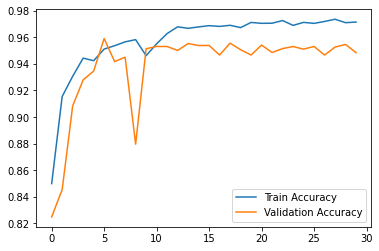

In [25]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()

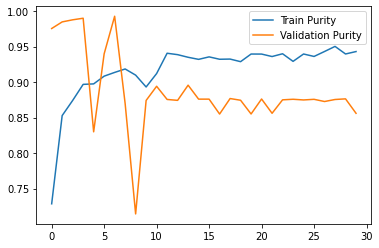

In [26]:
plt.plot(history.history['precision_1'], label="Train Purity")
plt.plot(history.history['val_precision_1'], label="Validation Purity")
plt.legend()

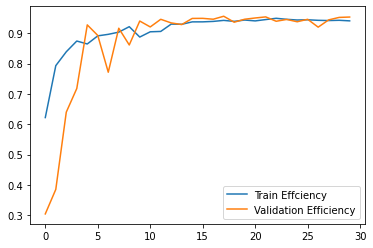

In [27]:
plt.plot(history.history['recall_1'], label="Train Effciency")
plt.plot(history.history['val_recall_1'], label="Validation Efficiency")
plt.legend()

In [28]:
! ls -1rt model_checkpoints/*.h5 | tail -n 1
!cp $(ls -1rt model_checkpoints/*.h5 | tail -n 1) model_checkpoints/last.h5

model_checkpoints/lite_model.006.h5


In [29]:
model.load_weights("model_checkpoints/last.h5")

In [30]:
probs = model.predict_on_batch(test_data)

0.9436910242885439


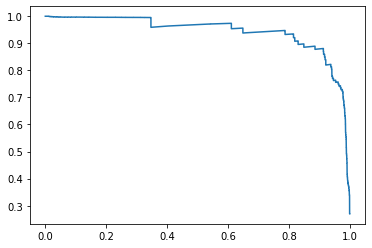

In [32]:
precision, recall, thresholds = precision_recall_curve(test_label, probs, sample_weight=test_weight)
plt.plot(recall, precision)
print(auc(recall, precision))